In [63]:
import pyomo.environ as pyo
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from matplotlib.ticker import FuncFormatter, MaxNLocator
from pyomo.opt import SolverFactory

In [38]:
# data
data = pd.read_excel('/Users/natomanzolli/Documents/GitHub/SAEVs/Data/inputs.xlsx')

In [39]:
def solve_opt(data, pass_min=0, pass_max=5990, mult_1=1, mult_2=1, tee=False): #data, pass_min=0, pass_max=5990, mult_1=1, mult_2=1, tee=False
    model = pyo.ConcreteModel()  # create model
    # vary mult 1 to create pareto front!!!
    t = 96
    k = 100
    D_passenger = (data['Total demand'] * mult_1).tolist()
    O_energy = (data['Outage'] * mult_2).tolist()
    Riding_price = 0.5
    P_buy = 0.1
    P_sell = 0.6
    alpha = 10
    beta = 7.2
    ch_eff = 0.90
    dch_eff = 1/0.9
    gama = 1.5  # 30km/h
    E_0 = 0.2
    E_min = 0.2
    E_max = 1
    R_bat = 150
    C_bat = 80
    Cycle = 3000
    DoD = 60
    T = 96
    delta_t = 0.25

    # sets
    model.T = pyo.RangeSet(t)  # set of timesteps
    model.K = pyo.RangeSet(k)  # set of SAEVs

    # parameters
    model.D_passenger = pyo.Param(model.T, initialize=lambda model, t: D_passenger[t-1])
    model.O_energy = pyo.Param(model.T, initialize=lambda model, t: O_energy[t-1])
    
    # binary variables
    model.b = pyo.Var(model.K, model.T, within=pyo.Binary)  # serving trip indicator
    model.x = pyo.Var(model.K, model.T, domain=pyo.Binary)    # charging indicator
    model.y = pyo.Var(model.K, model.T, domain=pyo.Binary)    # discharging indicator

    # non-negative variables
    model.e = pyo.Var(model.K, model.T, within=pyo.NonNegativeReals)  # energy level of bus k at time t
    model.w_buy = pyo.Var(model.T, within=pyo.NonNegativeReals)  # electricity purchased from the grid at time t
    model.w_sell = pyo.Var(model.T, within=pyo.NonNegativeReals)  # electricity sold to the grid at time t
    model.w_riding = pyo.Var(model.T, within=pyo.NonNegativeReals)  # number of trips performed at time t
    model.d = pyo.Var(model.T, within=pyo.NonNegativeReals)  # total degradation cost of the bus k battery at time t

    # constraints
    model.constraints = pyo.ConstraintList()  # Create a set of constraints

    # Each vehicle can perform at most one action at each timestep
    for k in model.K:
        for t in model.T:
            model.constraints.add(model.b[k, t] + model.x[k, t] + model.y[k, t] <= 1)
            
    # NEW CONSTRAINT: In the first time step, all vehicles should be charging.
    for k in model.K:
        model.constraints.add(model.x[k, 1] == 1)
        model.constraints.add(model.b[k, 1] == 0)
        model.constraints.add(model.y[k, 1] == 0)

    # Constraint for passenger demand (for each time step)
    for t in model.T:
        model.constraints.add(sum(model.b[k, t] for k in model.K) <= model.D_passenger[t])
    
    # The number of trips performed equals the number of vehicles serving at time t
    for t in model.T:
        model.constraints.add(sum(model.b[k, t] for k in model.K) == model.w_riding[t])
    
    # Passenger bounds
    model.constraints.add(sum(model.w_riding[t] for t in model.T) >= pass_min)
    model.constraints.add(sum(model.w_riding[t] for t in model.T) <= pass_max)

    # Energy update constraint for t>=2
    for k in model.K:
        for t in range(2, T + 1):
            model.constraints.add(model.e[k, t] == model.e[k, t-1] + delta_t * ch_eff * alpha * model.x[k, t] 
                                  - gama * model.b[k, t] - delta_t * dch_eff * beta * model.y[k, t])

    # Grid power balance for charging
    for t in model.T:
        model.constraints.add(delta_t * sum(ch_eff * alpha * model.x[k, t] for k in model.K) == model.w_buy[t])
    
    # Grid power balance for discharging
    for t in model.T:
        model.constraints.add(delta_t * sum(dch_eff * beta * model.y[k, t] for k in model.K) == model.w_sell[t])
    
    # Outage power limit
    for t in model.T:
        model.constraints.add(delta_t * sum(dch_eff * beta * model.y[k, t] for k in model.K) <= delta_t * model.O_energy[t])
    
    # Battery energy limits
    for k in model.K:
        for t in model.T:
            model.constraints.add(model.e[k, t] >= C_bat * E_min)
            model.constraints.add(model.e[k, t] <= C_bat * E_max)
    
    # Initial energy level and degradation cost
    for k in model.K:
        model.constraints.add(model.e[k, 1] == E_0 * C_bat)
    for t in model.T:
        model.constraints.add(model.d[t] == (R_bat / (Cycle * DoD)) * model.w_sell[t])

    # objective function
    def rule_obj(mod):
        return (sum(Riding_price * mod.w_riding[t] for t in mod.T) 
                - sum(P_buy * mod.w_buy[t] for t in mod.T) 
                + sum(P_sell * mod.w_sell[t] for t in mod.T)
                - sum(mod.d[t] for t in mod.T))
    model.obj = pyo.Objective(rule=rule_obj, sense=pyo.maximize)
    
    # SOLVER
    opt = pyo.SolverFactory('gurobi')
    opt.options['timelimit'] = 600
    opt.options['mipgap'] = 0.01
    results = opt.solve(model, tee=tee)
    print(results)
    return model


In [ ]:
def save_to_excel(model, filename='output.xlsx'):
	# Extract variables of interest
	T = list(model.T)
	K = list(model.K)
	# Serving, charging, discharging, energy, w_buy, w_sell
	serving = [sum(pyo.value(model.b[k, t]) for k in K) for t in T]
	charging = [sum(pyo.value(model.x[k, t]) for k in K) for t in T]
	discharging = [sum(pyo.value(model.y[k, t]) for k in K) for t in T]
	total_energy = [sum(pyo.value(model.e[k, t]) for k in K) for t in T]
	w_buy = [pyo.value(model.w_buy[t]) for t in T]
	w_sell = [pyo.value(model.w_sell[t]) for t in T]

	df = pd.DataFrame({
		'TimeStep': T,
		'Serving': serving,
		'Charging': charging,
		'Discharging': discharging,
		'TotalEnergy': total_energy,
		'W_buy': w_buy,
		'W_sell': w_sell
	})
	df.to_excel(filename, index=False)
	print(f"Results saved to {filename}")

In [89]:
def plot_variables(model, D_passenger, O_energy, t=96,
                   smooth=True, smooth_window=1, power_scale=4.0):
    """
    - Legends placed below each plot (outside axes).
    - Secondary y-axes use default black ticks/labels.
    - First plot (fleet composition) is NOT smoothed.
    - Charging/Discharging power series are scaled by `power_scale` (default 4×).
    - Uniform boxed look for all plots; no grid lines.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.ticker import FuncFormatter, MaxNLocator
    import pyomo.environ as pyo

    # ---------- Style (no grid; uniform spines) ----------
    plt.rcParams.update({
        "figure.facecolor": "white",
        "axes.facecolor": "white",
        "axes.edgecolor": "black",
        "axes.grid": False,            # no grid lines
        "font.size": 18,
        "axes.labelsize": 20,
        "axes.titlesize": 22,
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        "legend.fontsize": 16,
        "axes.linewidth": 1.5,
        "savefig.dpi": 300,
        "figure.dpi": 160,
    })

    # Colorblind-safe palette (Okabe–Ito + neutrals)
    COLORS = {
        "serving":      "#E69F00",
        "charging":     "#009E73",
        "discharging":  "#0072B2",
        "idle":         "#6A6A6A",
        "energy":       "#3F90DA",
        "buy":          "#8FD175",
        "sell":         "#B79F00",
        "demand":       "#4DB6AC",
        "outage":       "#D55E00",
    }

    def fmt_thousands(x, _): return f"{x:,.0f}"
    def fmt_percent(x, _):   return f"{x:.0f}%"

    def beautify_axes(ax, xlabel="Time [h]", ylabel=None, xlim=(0,24), xtick_every=2):
        ax.set_xlim(*xlim)
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax.set_xticks(np.arange(xlim[0], xlim[1] + 0.001, xtick_every))
        if xlabel: ax.set_xlabel(xlabel)
        if ylabel: ax.set_ylabel(ylabel)
        ax.grid(False)  # ensure no grid
        # full box around single-axis plots
        for side in ("left", "right", "bottom", "top"):
            ax.spines[side].set_visible(True)
            ax.spines[side].set_color("black")
            ax.spines[side].set_linewidth(1.5)

    def box_for_twin_axes(ax_left, ax_right):
        """Draw a single neat box across twin axes (no double borders)."""
        # Left axis: left/bottom/top visible; right hidden
        for side in ("left", "bottom", "top"):
            ax_left.spines[side].set_visible(True)
            ax_left.spines[side].set_color("black")
            ax_left.spines[side].set_linewidth(1.5)
        ax_left.spines["right"].set_visible(False)
        ax_left.grid(False)

        # Right axis: right visible; top/bottom/left hidden (avoid double lines)
        ax_right.spines["right"].set_visible(True)
        ax_right.spines["right"].set_color("black")
        ax_right.spines["right"].set_linewidth(1.5)
        for side in ("left", "top", "bottom"):
            ax_right.spines[side].set_visible(False)
        ax_right.grid(False)

    def legend_below(ax, ncol=3, pad_bottom=0.22):
        lg = ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.22),
                       ncol=ncol, frameon=True)
        ax.figure.subplots_adjust(bottom=pad_bottom)
        return lg

    def smooth_series(y, window=5, enabled=True):
        if (not enabled) or window <= 1:
            return np.asarray(y, dtype=float)
        y = np.asarray(y, dtype=float)
        w = np.ones(window) / window  # centered moving average
        return np.convolve(y, w, mode="same")

    # ---------- Time axis ----------
    T_list = sorted(list(model.T))
    assert len(T_list) == t, "Length of model.T must equal t."
    hours = np.arange(t) / 4.0  # 15-min slots → hours

    # ---------- Aggregate model outputs ----------
    K = list(model.K)
    fleet_size = float(len(K))

    serving = np.array([sum(pyo.value(model.b[k, tau]) for k in K) for tau in T_list], dtype=float)
    charging = np.array([sum(pyo.value(model.x[k, tau]) for k in K) for tau in T_list], dtype=float)
    dischg  = np.array([sum(pyo.value(model.y[k, tau]) for k in K) for tau in T_list], dtype=float)
    idle    = np.clip(fleet_size - serving - charging - dischg, 0, None)

    total_energy = np.array([sum(pyo.value(model.e[k, tau]) for k in K) for tau in T_list], dtype=float)
    w_buy  = np.array([pyo.value(model.w_buy[tau])  for tau in T_list], dtype=float)
    w_sell = np.array([pyo.value(model.w_sell[tau]) for tau in T_list], dtype=float)

    # Shares (% of fleet) — RAW for plot 1 (no smoothing)
    serving_pct  = 100.0 * serving / fleet_size
    charging_pct = 100.0 * charging / fleet_size
    dischg_pct   = 100.0 * dischg  / fleet_size
    idle_pct     = np.clip(100.0 - (serving_pct + charging_pct + dischg_pct), 0, 100)

    # External series
    D_passenger = np.asarray(D_passenger, dtype=float)
    O_energy    = np.asarray(O_energy, dtype=float)
    assert len(D_passenger) == t and len(O_energy) == t, "D_passenger and O_energy must have length t."

    # Smoothed versions for *other* plots
    total_energy_s = smooth_series(total_energy, smooth_window, enabled=smooth)
    w_buy_s        = smooth_series(w_buy,  smooth_window, enabled=smooth)
    w_sell_s       = smooth_series(w_sell, smooth_window, enabled=smooth)
    serving_pct_s  = smooth_series(serving_pct,  smooth_window, enabled=smooth)
    dischg_pct_s   = smooth_series(dischg_pct,   smooth_window, enabled=smooth)
    serving_s      = smooth_series(serving,      smooth_window, enabled=smooth)
    D_passenger_s  = smooth_series(D_passenger,  smooth_window, enabled=smooth)
    O_energy_s     = smooth_series(O_energy,     smooth_window, enabled=smooth)

    # Scale power series by 4× (15-min energy → kW-equivalent)
    w_buy_plot  = power_scale * w_buy_s
    w_sell_plot = power_scale * w_sell_s

    # ---------- 1) Fleet composition over time (stacked bars, %; NOT smoothed) ----------
    fig, ax = plt.subplots(figsize=(12, 5.5))
    width = 0.22  # bar width in hours
    ax.bar(hours, serving_pct,  width=width, color=COLORS["serving"],      alpha=0.85, label="Serving")
    ax.bar(hours, charging_pct, width=width, color=COLORS["charging"],     alpha=0.85, label="Charging",
           bottom=serving_pct)
    ax.bar(hours, dischg_pct,   width=width, color=COLORS["discharging"],  alpha=0.85, label="Discharging",
           bottom=serving_pct + charging_pct)
    ax.bar(hours, idle_pct,     width=width, color=COLORS["idle"],         alpha=0.75, label="Idle",
           bottom=serving_pct + charging_pct + dischg_pct)
    beautify_axes(ax, ylabel="Fleet [%]")
    ax.yaxis.set_major_formatter(FuncFormatter(fmt_percent))
    legend_below(ax, ncol=4, pad_bottom=0.24)
    plt.show()

    # ---------- 2) Total energy in fleet (kWh) ----------
    fig, ax = plt.subplots(figsize=(12, 5.25))
    ax.plot(hours, total_energy_s, linewidth=2.2, color=COLORS["energy"], label="Total Energy")
    beautify_axes(ax, ylabel="Energy [kWh]")
    ax.yaxis.set_major_formatter(FuncFormatter(fmt_thousands))
    legend_below(ax, ncol=1, pad_bottom=0.22)
    plt.show()

    # ---------- 3) Grid power: buy (G2V) vs sell (V2G) —----------
    fig, ax = plt.subplots(figsize=(12, 5.25))
    ax.plot(hours, w_buy_plot,  linewidth=2.0, label="Charging (G2V)",   color=COLORS["buy"])
    ax.plot(hours, w_sell_plot, linewidth=2.0, label="Discharging (V2G)", color=COLORS["sell"])
    beautify_axes(ax, ylabel="Power [kW]")
    ax.yaxis.set_major_formatter(FuncFormatter(fmt_thousands))
    legend_below(ax, ncol=2, pad_bottom=0.22)
    plt.show()

    # ---------- 4) Serving (%) vs Passenger demand ----------
    fig, ax1 = plt.subplots(figsize=(12, 5.25))
    ax1.plot(hours, serving_pct_s, linewidth=2.0, color=COLORS["serving"], label="Serving (%)")
    beautify_axes(ax1, ylabel="Vehicles [%]")
    ax1.yaxis.set_major_formatter(FuncFormatter(fmt_percent))
    ax2 = ax1.twinx()
    ax2.plot(hours, D_passenger_s, linewidth=2.0, color=COLORS["demand"], label="Passenger Demand")
    ax2.set_ylabel("Passengers")  # default black ticks/label
    ax2.yaxis.set_major_formatter(FuncFormatter(fmt_thousands))
    box_for_twin_axes(ax1, ax2)   # single clean box
    lines, labels = [], []
    for a in (ax1, ax2):
        L, lab = a.get_legend_handles_labels()
        lines += L; labels += lab
    ax1.legend(lines, labels, loc="upper center", bbox_to_anchor=(0.5, -0.22), ncol=2, frameon=True)
    ax1.figure.subplots_adjust(bottom=0.22)
    plt.show()

    # ---------- 5) Discharging (%) vs Outage demand ----------
    fig, ax1 = plt.subplots(figsize=(12, 5.25))
    width = 0.22
    ax1.bar(hours, dischg_pct_s, width=width, color=COLORS["discharging"], alpha=0.85, label="Discharging (%)")
    beautify_axes(ax1, ylabel="Vehicles [%]")
    ax1.yaxis.set_major_formatter(FuncFormatter(fmt_percent))
    ax2 = ax1.twinx()
    ax2.plot(hours, O_energy_s, linewidth=2.0, color=COLORS["outage"], label="Outage Demand")
    ax2.set_ylabel("Power [kW]")  # default black
    ax2.yaxis.set_major_formatter(FuncFormatter(fmt_thousands))
    box_for_twin_axes(ax1, ax2)
    lines, labels = [], []
    for a in (ax1, ax2):
        L, lab = a.get_legend_handles_labels()
        lines += L; labels += lab
    ax1.legend(lines, labels, loc="upper center", bbox_to_anchor=(0.5, -0.22), ncol=2, frameon=True)
    ax1.figure.subplots_adjust(bottom=0.22)
    plt.show()

    # ---------- 6) Serving count vs V2G power -------------
    fig, ax1 = plt.subplots(figsize=(12, 5.25))
    width = 0.22
    ax1.bar(hours, serving_s, width=width, color=COLORS["serving"], alpha=0.85, label="Serving (count)")
    beautify_axes(ax1, ylabel="Vehicles")
    ax2 = ax1.twinx()
    ax2.plot(hours, w_sell_plot, linewidth=2.0, color=COLORS["sell"], label="V2G Power")
    ax2.set_ylabel("Power [kW]")  # default black
    ax2.yaxis.set_major_formatter(FuncFormatter(fmt_thousands))
    box_for_twin_axes(ax1, ax2)
    lines, labels = [], []
    for a in (ax1, ax2):
        L, lab = a.get_legend_handles_labels()
        lines += L; labels += lab
    ax1.legend(lines, labels, loc="upper center", bbox_to_anchor=(0.5, -0.22), ncol=2, frameon=True)
    ax1.figure.subplots_adjust(bottom=0.22)
    plt.show()


In [91]:
model = solve_opt(data,pass_min=2000, mult_2=0,tee=False) # vary pass_min=2000 mult_2=0 (transportation scenario) / pass_min=0 mult_2=1 (outage scenario)


Problem: 
- Name: x1
  Lower bound: 1954.274999999998
  Upper bound: 1972.5
  Number of objectives: 1
  Number of constraints: 39278
  Number of variables: 38784
  Number of binary variables: 28800
  Number of integer variables: 28800
  Number of continuous variables: 9984
  Number of nonzeros: 144572
  Sense: maximize
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Wall time: 0.7941980361938477
  Error rc: 0
  Time: 1.3298671245574951
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



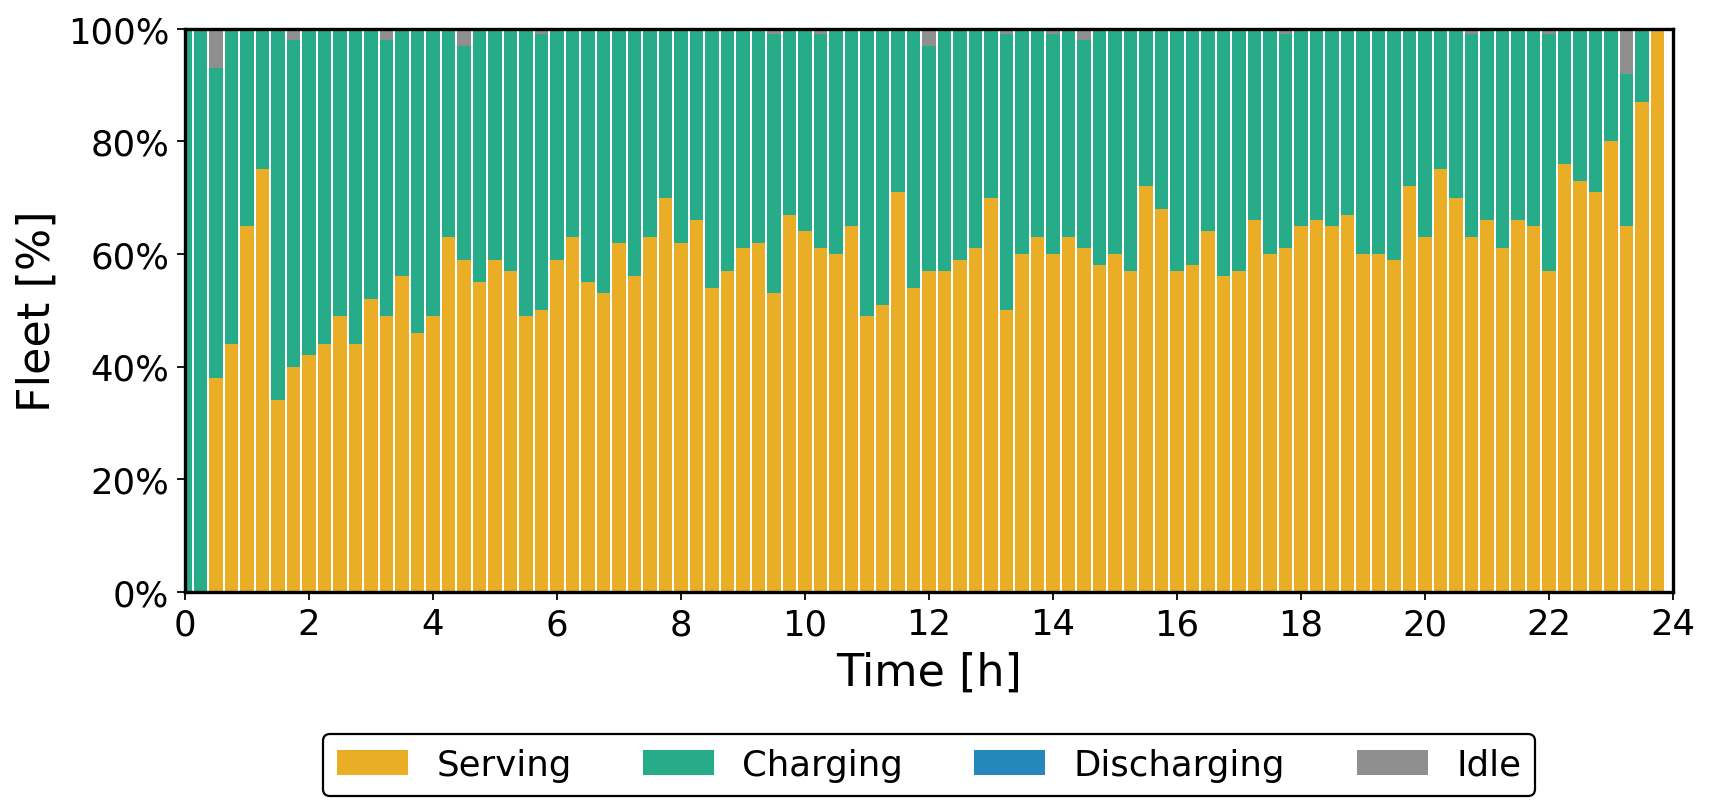

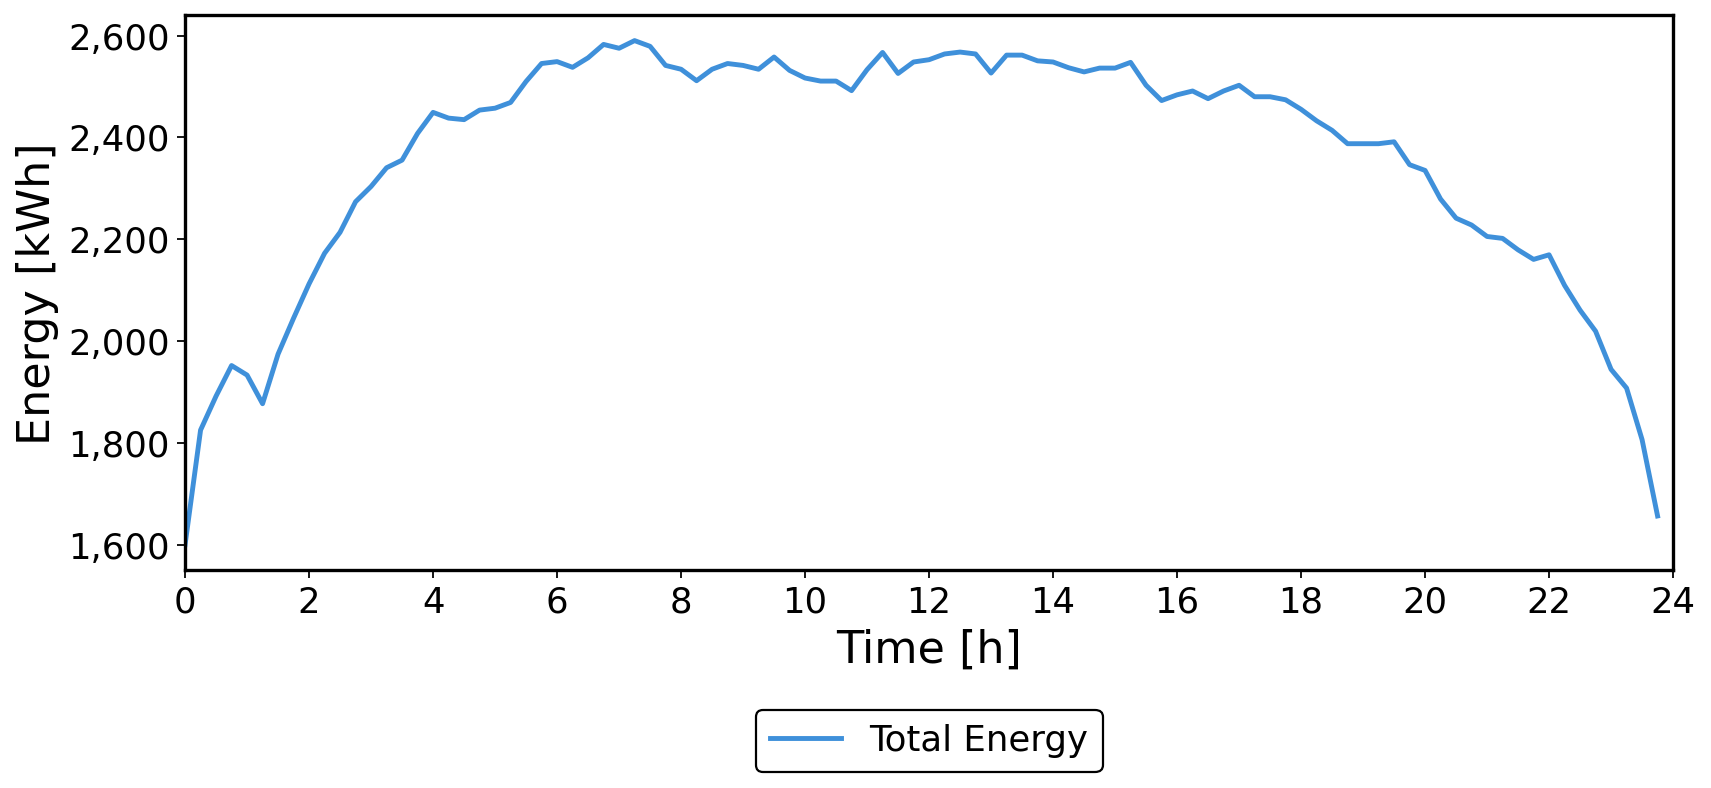

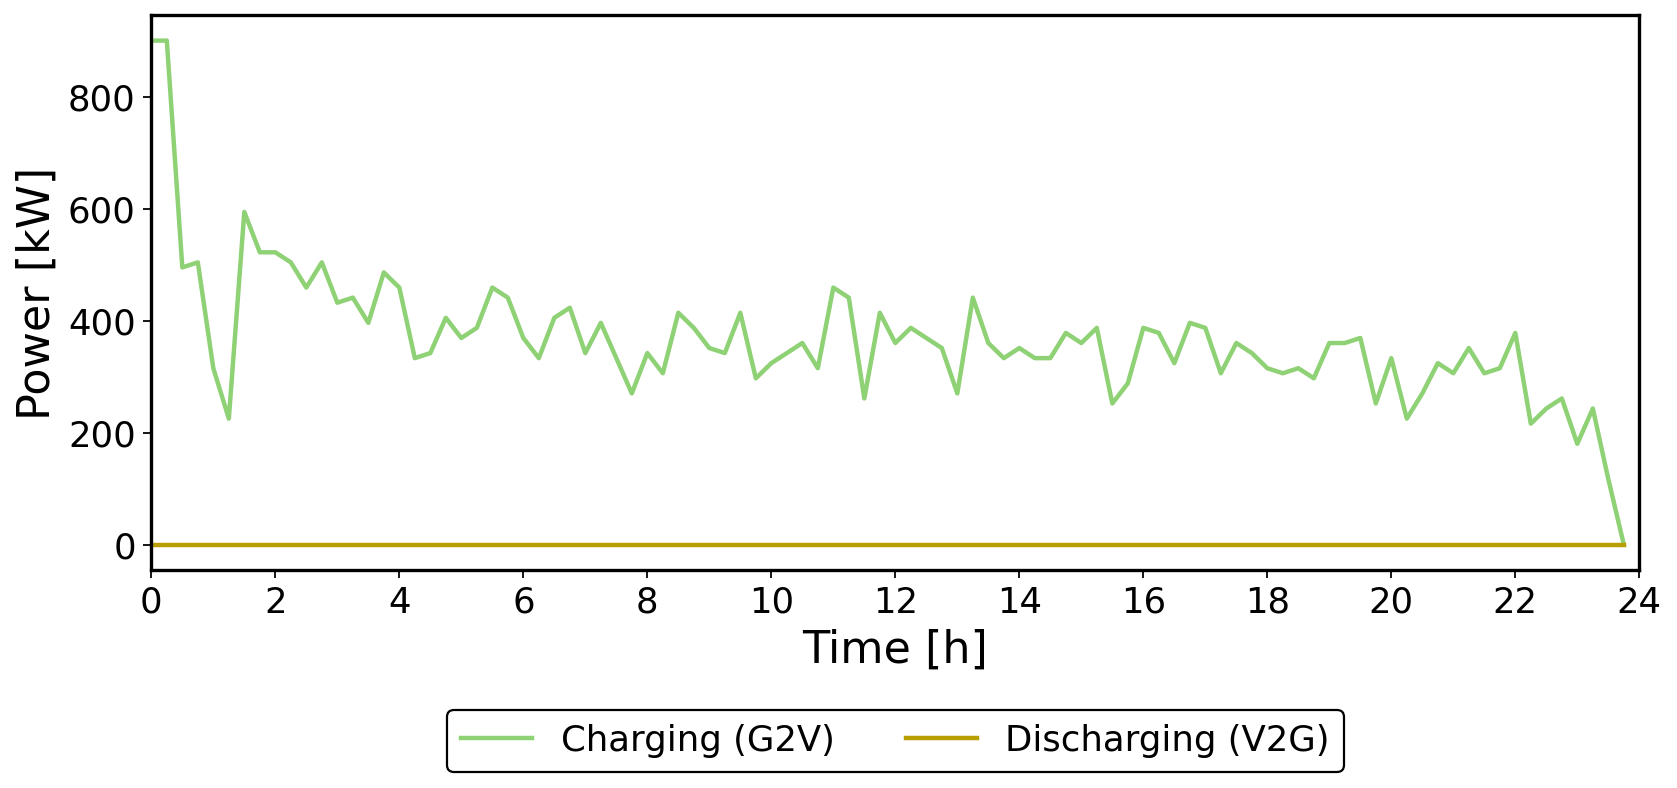

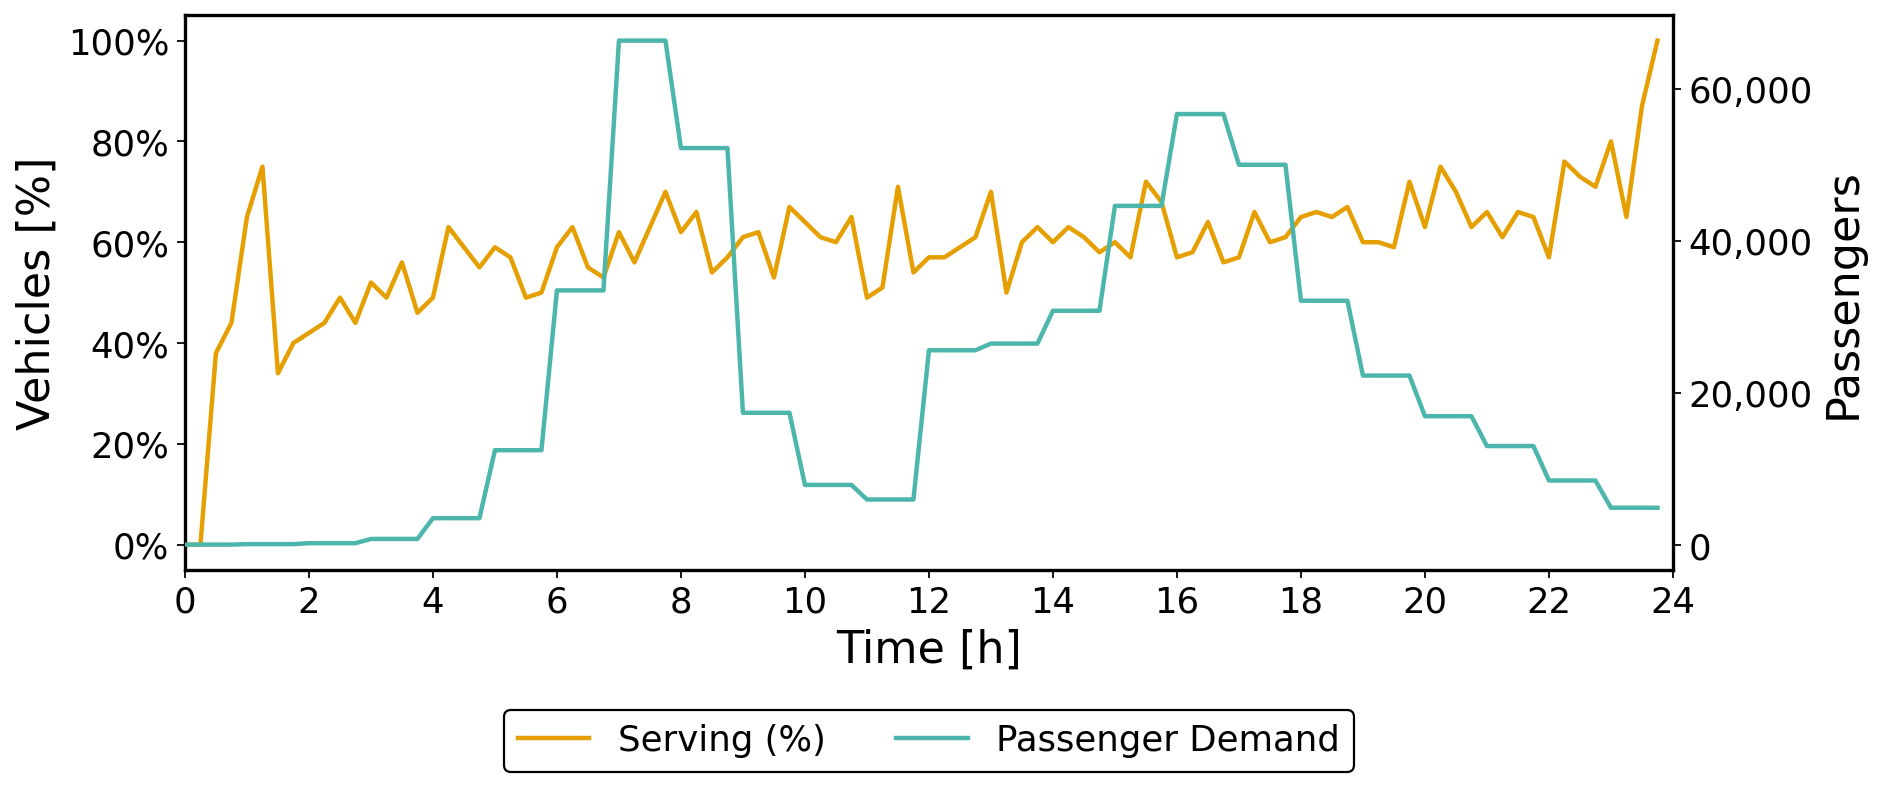

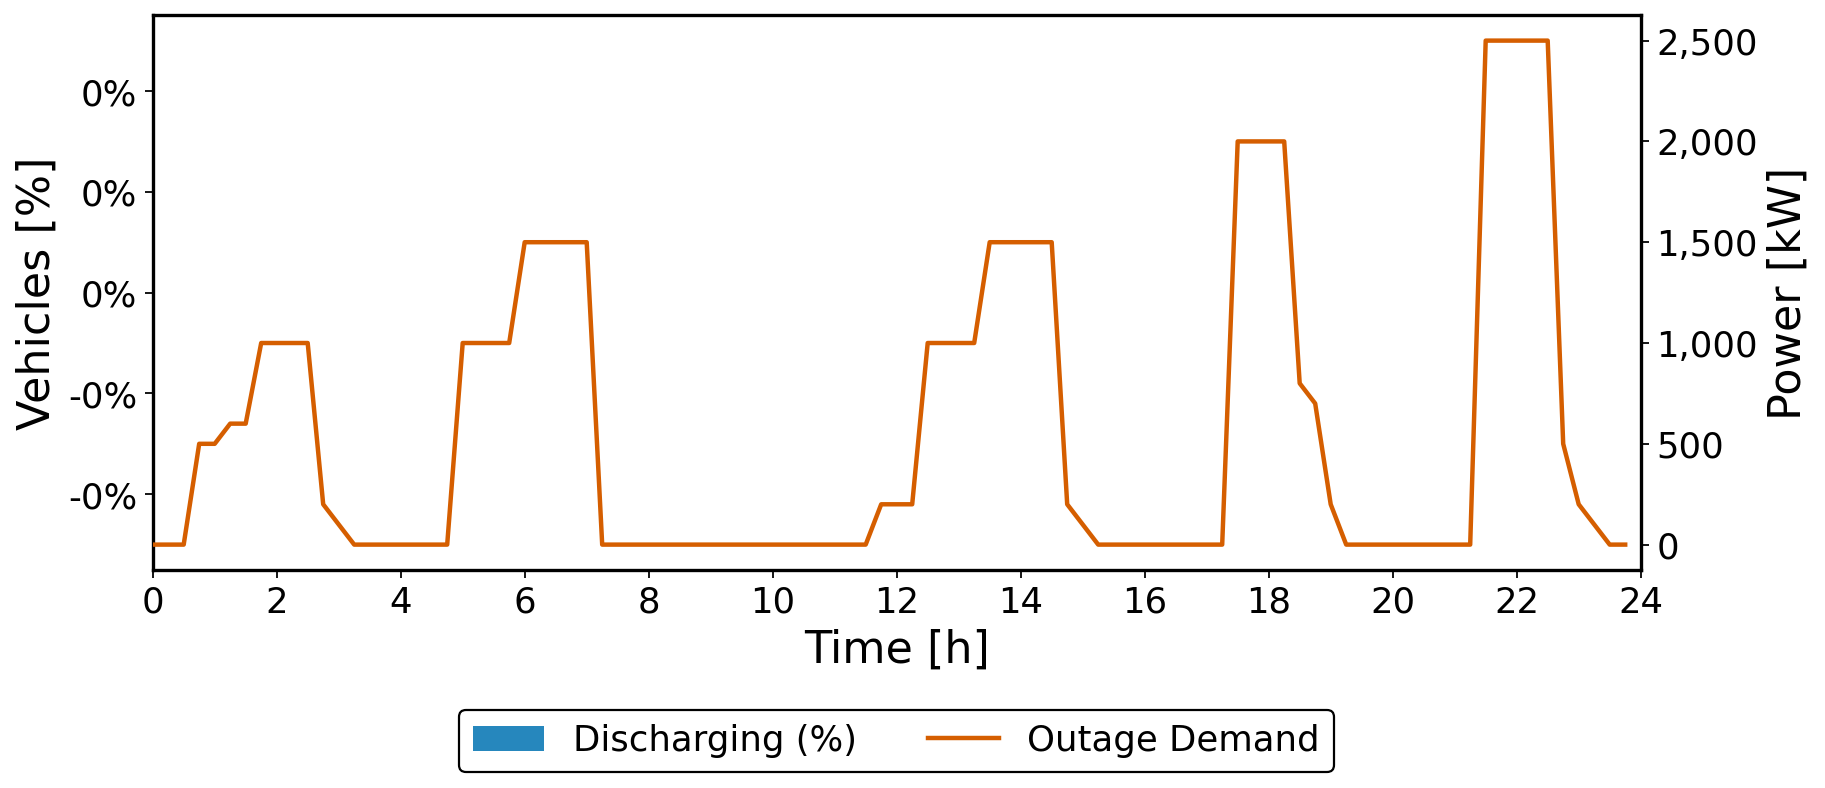

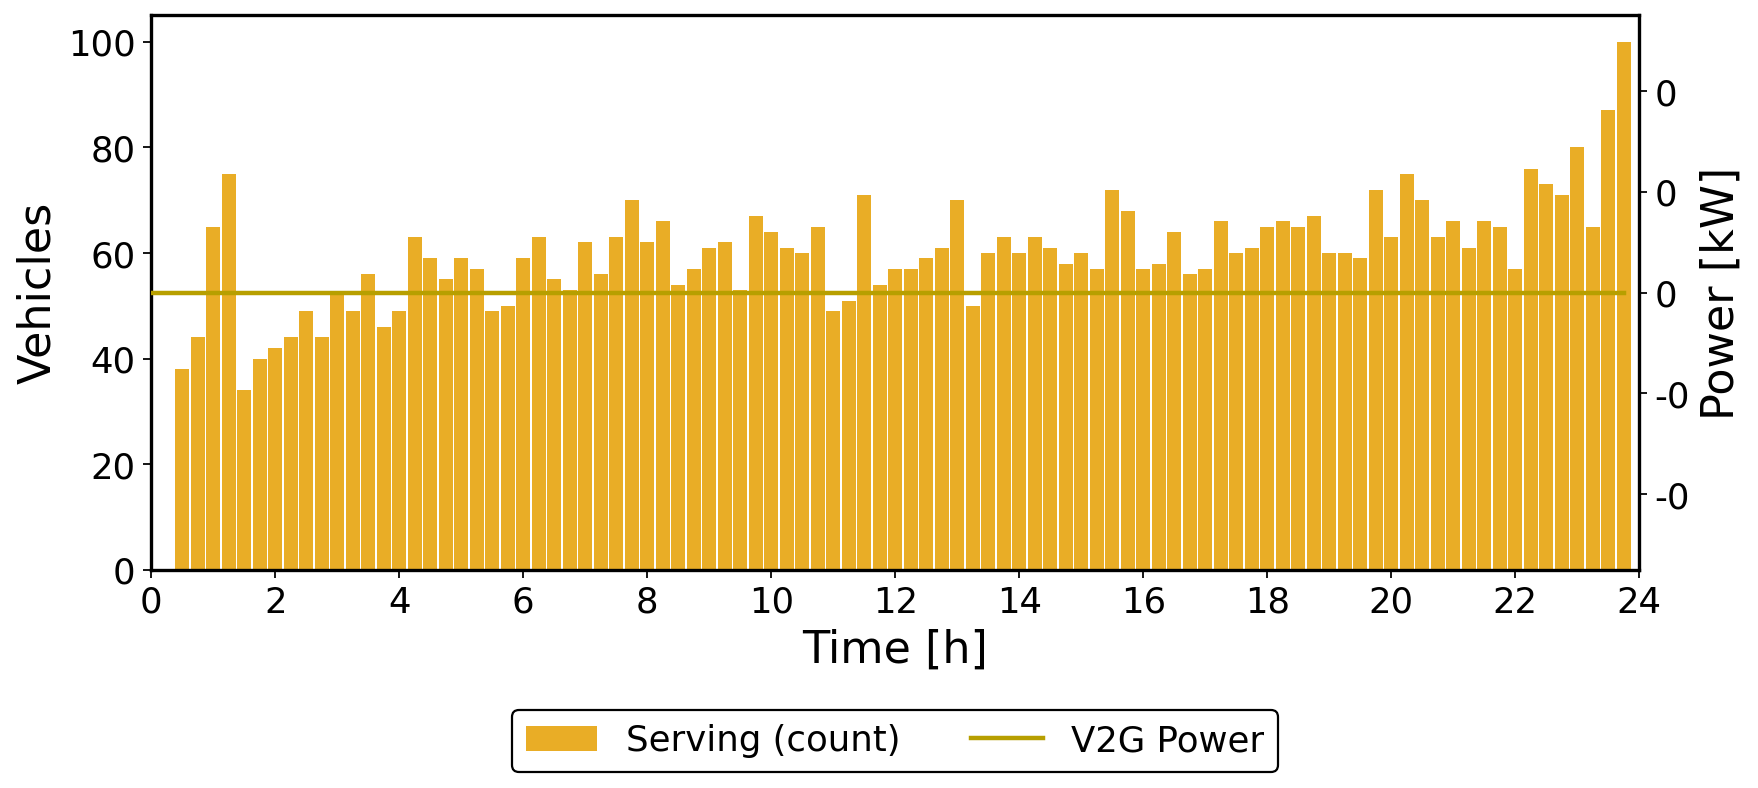

In [92]:
D_passenger = (data['Total demand'][:96]).tolist()
O_energy = (data['Outage'][:96]).tolist()
plot_variables(model, D_passenger, O_energy)

In [43]:
# Create a dynamic filename
filename = 'output_energy.xlsx'
# Save results to Excel
save_to_excel(model, filename=filename)

Results saved to output_energy.xlsx
